In [5]:
"""
  TensorFlow translation of the torch example found here (written by SeanNaren).
  https://github.com/SeanNaren/TorchQLearningExample
  Original keras example found here (written by Eder Santana).
  https://gist.github.com/EderSantana/c7222daa328f0e885093#file-qlearn-py-L164
  The agent plays a game of catch. Fruits drop from the sky and the agent can choose the actions
  left/stay/right to catch the fruit before it reaches the ground.
"""

import tensorflow as tf
import numpy as np
import random
import math
import os
tf.compat.v1.disable_eager_execution()

# Parameters
epsilon = 1  # The probability of choosing a random action (in training). This decays as iterations increase. (0 to 1)
epsilonMinimumValue = 0.001 # The minimum value we want epsilon to reach in training. (0 to 1)
nbActions = 3 # The number of actions. Since we only have left/stay/right that means 3 actions.
epoch = 1001 # The number of games we want the system to run for.
hiddenSize = 100 # Number of neurons in the hidden layers.
maxMemory = 500 # How large should the memory be (where it stores its past experiences).
batchSize = 50 # The mini-batch size for training. Samples are randomly taken from memory till mini-batch size.
gridSize = 10 # The size of the grid that the agent is going to play the game on.
nbStates = gridSize * gridSize # We eventually flatten to a 1d tensor to feed the network.
discount = 0.9 # The discount is used to force the network to choose states that lead to the reward quicker (0 to 1)
learningRate = 0.2 # Learning Rate for Stochastic Gradient Descent (our optimizer).

# Create the base model.
X = tf.compat.v1.placeholder(tf.float32, [None, nbStates])
W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates))))
b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01))
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)
W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))
b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01))
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2)
W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

# True labels
Y = tf.compat.v1.placeholder(tf.float32, [None, nbActions])

# Mean squared error cost function
cost = tf.reduce_sum(input_tensor=tf.square(Y-output_layer)) / (2*batchSize)

# Stochastic Gradient Decent Optimizer
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)


# Helper function: Chooses a random value between the two boundaries.
def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;


# The environment: Handles interactions and contains the state of the environment
class CatchEnvironment():
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8)

      # Returns the state of the environment.
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas

    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas[self.state[0]-1, self.state[1]-1] = 1  # Draw the fruit.
        # Draw the basket. The basket takes the adjacent two places to the position of basket.
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1
        return canvas

    # Resets the environment. Randomly initialise the fruit position (always at the top to begin with) and bucket.
    def reset(self):
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition])
        return self.getState()

    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

    # Returns the award that the agent has gained for being in the current environment state.
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
              return 0

    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1):
            return True
        else:
            return False

    def updateState(self, action):
        if (action == 1):
            action = -1
        elif (action == 2):
            action = 0
        else:
            action = 1
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1) # The min/max prevents the basket from moving out of the grid.
        fruitRow = fruitRow + 1  # The fruit is falling by 1 every action.
        self.state = np.array([fruitRow, fruitColumn, newBasket])

    #Action can be 1 (move left) or 2 (move right)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState()   # For purpose of the visual, I also return the state.


# The memory: Handles the internal memory that we add experiences that occur based on agent's actions,
# and creates batches of experiences based on the mini-batch size for training.
class ReplayMemory:
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8)
        self.count = 0
        self.current = 0

    # Appends the experience to the memory.
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):

        # We check to see if we have enough memory inputs to make an entire batch, if not we create the biggest
        # batch we can (at the beginning of training we will not have enough experience to fill a batch).
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)

        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        # Fill the inputs and targets up.
        for i in range(chosenBatchSize):
            if memoryLength == 1:
                memoryLength = 2
            # Choose a random memory experience to add to the batch.
            randomIndex = random.randrange(1, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))

            target = sess.run(model, feed_dict={X: current_inputState})

            current_nextState =  np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})

            # Gives us Q_sa, the max q for the next state.
            nextStateMaxQ = np.amax(current_outputs)
            if (self.gameOver[randomIndex] == True):
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # reward + discount(gamma) * max_a' Q(s',a')
                # We are setting the Q-value for the action to  r + gamma*max a' Q(s', a'). The rest stay the same
                # to give an error of 0 for those outputs.
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] + self.discount * nextStateMaxQ

            # Update the inputs and targets.
            inputs[i] = current_inputState
            targets[i] = target

        return inputs, targets


def main(_):
    print("Training new model")

    # Define Environment
    env = CatchEnvironment(gridSize)

    # Define Replay Memory
    memory = ReplayMemory(gridSize, maxMemory, discount)

    # Add ops to save and restore all the variables.
    saver = tf.compat.v1.train.Saver()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth=True
    
    winCount = 0
    with tf.compat.v1.Session(config=config) as sess:
        tf.compat.v1.global_variables_initializer().run()

        for i in range(epoch):
            # Initialize the environment.
            err = 0
            env.reset()

            isGameOver = False

            # The initial state of the environment.
            currentState = env.observe()

            while (isGameOver != True):
                action = -9999  # action initilization
                # Decides if we should choose a random action, or an action from the policy network.
                global epsilon
                if (randf(0, 1) <= epsilon):
                    action = random.randrange(1, nbActions+1)
                else:
                    # Forward the current state through the network.
                    q = sess.run(output_layer, feed_dict={X: currentState})
                    # Find the max index (the chosen action).
                    index = q.argmax()
                    action = index + 1

                # Decay the epsilon by multiplying by 0.999, not allowing it to go below a certain threshold.
                if (epsilon > epsilonMinimumValue):
                    epsilon = epsilon * 0.999

                nextState, reward, gameOver, stateInfo = env.act(action)

                if (reward == 1):
                    winCount = winCount + 1

                memory.remember(currentState, action, reward, nextState, gameOver)

                # Update the current state and if the game is over.
                currentState = nextState
                isGameOver = gameOver

                # We get a batch of training data to train the model.
                inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)

                # Train the network which returns the error.
                _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})
                err = err + loss

            print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)*100))

        # Save the variables to disk.
        save_path = saver.save(sess, os.getcwd()+"/model.ckpt")
        print("Model saved in file: %s" % save_path)

if __name__ == '__main__':
    tf.compat.v1.app.run()

Training new model
Epoch 0: err = 56.284073968825396: Win count = 0 Win ratio = 0.0
Epoch 1: err = 0.2289224984124303: Win count = 0 Win ratio = 0.0
Epoch 2: err = 0.17473086528480053: Win count = 0 Win ratio = 0.0
Epoch 3: err = 0.2146527972072363: Win count = 0 Win ratio = 0.0
Epoch 4: err = 0.24534913338720798: Win count = 0 Win ratio = 0.0
Epoch 5: err = 0.28938273526728153: Win count = 0 Win ratio = 0.0
Epoch 6: err = 0.3144905511289835: Win count = 1 Win ratio = 14.285714285714285
Epoch 7: err = 0.4224841706454754: Win count = 2 Win ratio = 25.0
Epoch 8: err = 0.38405516371130943: Win count = 2 Win ratio = 22.22222222222222
Epoch 9: err = 0.3636403661221266: Win count = 2 Win ratio = 20.0
Epoch 10: err = 0.4268132708966732: Win count = 3 Win ratio = 27.27272727272727
Epoch 11: err = 0.39141203835606575: Win count = 4 Win ratio = 33.33333333333333
Epoch 12: err = 0.3793050218373537: Win count = 4 Win ratio = 30.76923076923077
Epoch 13: err = 0.42398036643862724: Win count = 4 Win 

Epoch 104: err = 0.2348154354840517: Win count = 35 Win ratio = 33.33333333333333
Epoch 105: err = 0.2534106895327568: Win count = 35 Win ratio = 33.0188679245283
Epoch 106: err = 0.2588354106992483: Win count = 36 Win ratio = 33.64485981308411
Epoch 107: err = 0.21571839600801468: Win count = 37 Win ratio = 34.25925925925926
Epoch 108: err = 0.24492416344583035: Win count = 37 Win ratio = 33.94495412844037
Epoch 109: err = 0.2998412549495697: Win count = 38 Win ratio = 34.54545454545455
Epoch 110: err = 0.23365193605422974: Win count = 38 Win ratio = 34.234234234234236
Epoch 111: err = 0.3005945747718215: Win count = 39 Win ratio = 34.82142857142857
Epoch 112: err = 0.22617647796869278: Win count = 40 Win ratio = 35.39823008849557
Epoch 113: err = 0.19024115521460772: Win count = 41 Win ratio = 35.96491228070175
Epoch 114: err = 0.29958862997591496: Win count = 41 Win ratio = 35.65217391304348
Epoch 115: err = 0.25418204814195633: Win count = 41 Win ratio = 35.3448275862069
Epoch 116:

Epoch 204: err = 0.07568483101204038: Win count = 78 Win ratio = 38.048780487804876
Epoch 205: err = 0.12250511860474944: Win count = 78 Win ratio = 37.86407766990291
Epoch 206: err = 0.0929974322207272: Win count = 78 Win ratio = 37.68115942028986
Epoch 207: err = 0.09541455376893282: Win count = 79 Win ratio = 37.980769230769226
Epoch 208: err = 0.08708349009975791: Win count = 79 Win ratio = 37.79904306220095
Epoch 209: err = 0.09262139908969402: Win count = 79 Win ratio = 37.61904761904762
Epoch 210: err = 0.1029569897800684: Win count = 79 Win ratio = 37.44075829383886
Epoch 211: err = 0.12576328637078404: Win count = 80 Win ratio = 37.735849056603776
Epoch 212: err = 0.13662433810532093: Win count = 81 Win ratio = 38.028169014084504
Epoch 213: err = 0.12494030175730586: Win count = 82 Win ratio = 38.31775700934579
Epoch 214: err = 0.11977640027180314: Win count = 82 Win ratio = 38.139534883720934
Epoch 215: err = 0.13757335301488638: Win count = 83 Win ratio = 38.425925925925924


Epoch 303: err = 0.05746011296287179: Win count = 142 Win ratio = 46.71052631578947
Epoch 304: err = 0.06866439338773489: Win count = 143 Win ratio = 46.885245901639344
Epoch 305: err = 0.05336840217933059: Win count = 144 Win ratio = 47.05882352941176
Epoch 306: err = 0.034222920425236225: Win count = 145 Win ratio = 47.23127035830619
Epoch 307: err = 0.04651713790372014: Win count = 145 Win ratio = 47.07792207792208
Epoch 308: err = 0.03562117647379637: Win count = 145 Win ratio = 46.92556634304207
Epoch 309: err = 0.09089761995710433: Win count = 146 Win ratio = 47.096774193548384
Epoch 310: err = 0.04916604422032833: Win count = 147 Win ratio = 47.266881028938904
Epoch 311: err = 0.09216006426140666: Win count = 148 Win ratio = 47.43589743589743
Epoch 312: err = 0.08504284592345357: Win count = 149 Win ratio = 47.6038338658147
Epoch 313: err = 0.04794148658402264: Win count = 149 Win ratio = 47.452229299363054
Epoch 314: err = 0.048058050917461514: Win count = 150 Win ratio = 47.61

Epoch 401: err = 0.012094823003280908: Win count = 228 Win ratio = 56.71641791044776
Epoch 402: err = 0.013889670313801616: Win count = 229 Win ratio = 56.82382133995038
Epoch 403: err = 0.014088235271628946: Win count = 230 Win ratio = 56.930693069306926
Epoch 404: err = 0.01367556006880477: Win count = 231 Win ratio = 57.03703703703704
Epoch 405: err = 0.019040834507904947: Win count = 232 Win ratio = 57.14285714285714
Epoch 406: err = 0.015417011163663119: Win count = 232 Win ratio = 57.00245700245701
Epoch 407: err = 0.01071178849088028: Win count = 233 Win ratio = 57.107843137254896
Epoch 408: err = 0.015203937247861177: Win count = 234 Win ratio = 57.21271393643031
Epoch 409: err = 0.013140240160282701: Win count = 235 Win ratio = 57.3170731707317
Epoch 410: err = 0.010969086433760822: Win count = 236 Win ratio = 57.420924574209245
Epoch 411: err = 0.013744114898145199: Win count = 237 Win ratio = 57.52427184466019
Epoch 412: err = 0.009368144324980676: Win count = 238 Win ratio 

Epoch 498: err = 0.00595529074780643: Win count = 319 Win ratio = 63.92785571142284
Epoch 499: err = 0.004486283418373205: Win count = 320 Win ratio = 64.0
Epoch 500: err = 0.005112091836053878: Win count = 321 Win ratio = 64.07185628742515
Epoch 501: err = 0.004966116219293326: Win count = 322 Win ratio = 64.14342629482071
Epoch 502: err = 0.0052953414269723: Win count = 323 Win ratio = 64.21471172962227
Epoch 503: err = 0.004364333697594702: Win count = 324 Win ratio = 64.28571428571429
Epoch 504: err = 0.0060621029115282: Win count = 325 Win ratio = 64.35643564356435
Epoch 505: err = 0.004181656724540517: Win count = 326 Win ratio = 64.42687747035573
Epoch 506: err = 0.0052997368620708585: Win count = 327 Win ratio = 64.49704142011834
Epoch 507: err = 0.004422974452609196: Win count = 328 Win ratio = 64.56692913385827
Epoch 508: err = 0.005208419956034049: Win count = 329 Win ratio = 64.63654223968565
Epoch 509: err = 0.003988157783169299: Win count = 330 Win ratio = 64.705882352941

Epoch 595: err = 0.0007657304668100551: Win count = 404 Win ratio = 67.78523489932886
Epoch 596: err = 0.0006350114636006765: Win count = 405 Win ratio = 67.8391959798995
Epoch 597: err = 0.0008639410007162951: Win count = 406 Win ratio = 67.89297658862876
Epoch 598: err = 0.0009569119865773246: Win count = 406 Win ratio = 67.779632721202
Epoch 599: err = 0.0010481468598300125: Win count = 407 Win ratio = 67.83333333333333
Epoch 600: err = 0.0007991269740159623: Win count = 408 Win ratio = 67.88685524126456
Epoch 601: err = 0.0009442150803806726: Win count = 409 Win ratio = 67.94019933554817
Epoch 602: err = 0.0007919783674879: Win count = 409 Win ratio = 67.82752902155887
Epoch 603: err = 0.0006133753813628573: Win count = 410 Win ratio = 67.88079470198676
Epoch 604: err = 0.0006146998093754519: Win count = 410 Win ratio = 67.76859504132231
Epoch 605: err = 0.0006250694241316523: Win count = 411 Win ratio = 67.82178217821783
Epoch 606: err = 0.0006182373072078917: Win count = 412 Win 

Epoch 692: err = 0.00550840690266341: Win count = 489 Win ratio = 70.56277056277057
Epoch 693: err = 0.007587473199237138: Win count = 490 Win ratio = 70.60518731988472
Epoch 694: err = 0.0028792935190722346: Win count = 491 Win ratio = 70.64748201438849
Epoch 695: err = 0.004289695134502836: Win count = 491 Win ratio = 70.54597701149426
Epoch 696: err = 0.00461096377694048: Win count = 492 Win ratio = 70.58823529411765
Epoch 697: err = 0.004105262385564856: Win count = 493 Win ratio = 70.63037249283668
Epoch 698: err = 0.0024457015097141266: Win count = 494 Win ratio = 70.67238912732475
Epoch 699: err = 0.00238689492107369: Win count = 495 Win ratio = 70.71428571428572
Epoch 700: err = 0.0033553523826412857: Win count = 496 Win ratio = 70.75606276747504
Epoch 701: err = 0.0033459304249845445: Win count = 497 Win ratio = 70.7977207977208
Epoch 702: err = 0.0019615054625319317: Win count = 498 Win ratio = 70.83926031294452
Epoch 703: err = 0.0021852772624697536: Win count = 499 Win rati

Epoch 788: err = 0.0006009665594319813: Win count = 577 Win ratio = 73.13054499366287
Epoch 789: err = 0.0005343199554772582: Win count = 578 Win ratio = 73.16455696202532
Epoch 790: err = 0.001045066939695971: Win count = 579 Win ratio = 73.19848293299621
Epoch 791: err = 0.0007878199794504326: Win count = 580 Win ratio = 73.23232323232324
Epoch 792: err = 0.0007029457756289048: Win count = 581 Win ratio = 73.26607818411097
Epoch 793: err = 0.0003946161232306622: Win count = 582 Win ratio = 73.29974811083123
Epoch 794: err = 0.000658372478937963: Win count = 583 Win ratio = 73.33333333333333
Epoch 795: err = 0.0005029133208154235: Win count = 584 Win ratio = 73.36683417085426
Epoch 796: err = 0.0004800845017598476: Win count = 585 Win ratio = 73.40025094102886
Epoch 797: err = 0.0005824307754664915: Win count = 586 Win ratio = 73.43358395989975
Epoch 798: err = 0.002893945260439068: Win count = 587 Win ratio = 73.46683354192741
Epoch 799: err = 0.00039697861757304054: Win count = 588 

Epoch 884: err = 0.0005588062249444192: Win count = 667 Win ratio = 75.36723163841808
Epoch 885: err = 0.0005409343211795203: Win count = 668 Win ratio = 75.39503386004515
Epoch 886: err = 0.00033937525859073503: Win count = 669 Win ratio = 75.42277339346111
Epoch 887: err = 0.0005608667343039997: Win count = 670 Win ratio = 75.45045045045045
Epoch 888: err = 0.0004751161304739071: Win count = 671 Win ratio = 75.47806524184477
Epoch 889: err = 0.0003527450007823063: Win count = 671 Win ratio = 75.3932584269663
Epoch 890: err = 0.0006194644665811211: Win count = 672 Win ratio = 75.42087542087542
Epoch 891: err = 0.0004795521708729211: Win count = 673 Win ratio = 75.44843049327355
Epoch 892: err = 0.0004598671948770061: Win count = 674 Win ratio = 75.47592385218364
Epoch 893: err = 0.00042987949473172193: Win count = 675 Win ratio = 75.50335570469798
Epoch 894: err = 0.0005578744385275058: Win count = 676 Win ratio = 75.53072625698324
Epoch 895: err = 0.000560530946131621: Win count = 67

Epoch 980: err = 0.00018030943920166465: Win count = 757 Win ratio = 77.16615698267074
Epoch 981: err = 0.0001642526508476294: Win count = 758 Win ratio = 77.18940936863544
Epoch 982: err = 8.47155524752452e-05: Win count = 759 Win ratio = 77.21261444557477
Epoch 983: err = 0.0001599360648469883: Win count = 760 Win ratio = 77.23577235772358
Epoch 984: err = 0.00013618422099170857: Win count = 761 Win ratio = 77.25888324873097
Epoch 985: err = 0.00016256672597592114: Win count = 762 Win ratio = 77.28194726166329
Epoch 986: err = 0.00020552020600916876: Win count = 763 Win ratio = 77.30496453900709
Epoch 987: err = 0.00018176711000705836: Win count = 764 Win ratio = 77.32793522267207
Epoch 988: err = 0.0005552993459332356: Win count = 765 Win ratio = 77.35085945399393
Epoch 989: err = 0.00013885171938454732: Win count = 766 Win ratio = 77.37373737373737
Epoch 990: err = 0.0008784648016444407: Win count = 767 Win ratio = 77.3965691220989
Epoch 991: err = 0.000186351060619927: Win count =

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


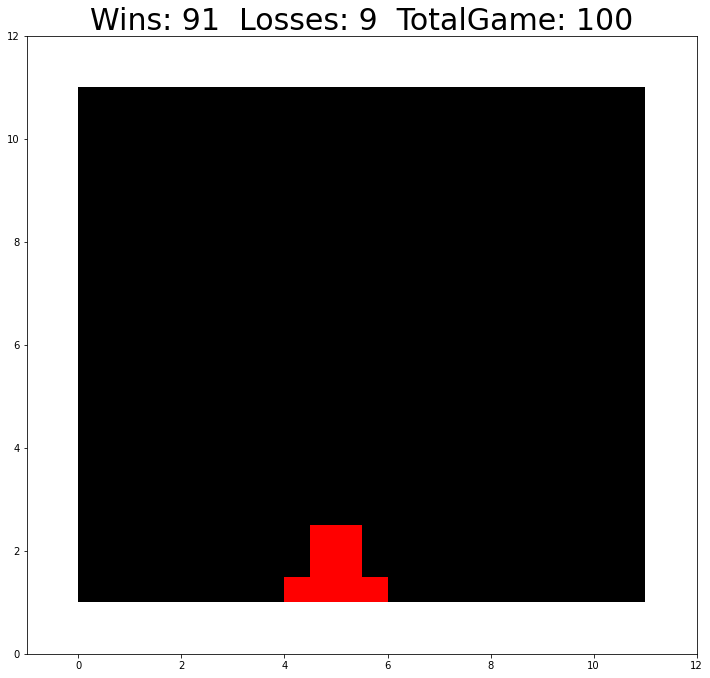

In [20]:
# To run this code you must use iPython. Also you can use the .ipynb file in ipython notebook mode.

%matplotlib
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab as pl
import time
import tensorflow as tf
import math
import os

gridSize = 10 # The size of the grid that the agent is going to play the game on.
maxGames = 100
env = CatchEnvironment(gridSize)
winCount = 0
loseCount = 0
numberOfGames = 0

ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

# Add ops to save and restore all the variables.
saver = tf.compat.v1.train.Saver()

def drawState(fruitRow, fruitColumn, basket):
    global gridSize
    # column is the x axis
    fruitX = fruitColumn 
    # Invert matrix style points to coordinates
    fruitY = (gridSize - fruitRow + 1)
    statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
    axis.set_title(statusTitle, fontsize=30)
    for p in [
        patches.Rectangle(
            ((ground - 1), (ground)), 11, 10,
            facecolor="#000000"      # Black
        ),
        patches.Rectangle(
            (basket - 1, ground), 2, 0.5,
            facecolor="#FF0000"     # No background
        ),
        patches.Rectangle(
            (fruitX - 0.5, fruitY - 0.5), 1, 1,
            facecolor="#FF0000"       # red 
        ),   
    ]:
        axis.add_patch(p)
        display.clear_output(wait=True)
        display.display(pl.gcf())

with tf.compat.v1.Session() as sess:    
    # Restore variables from disk.
    saver.restore(sess, os.getcwd()+"/model.ckpt")
    print('saved model is loaded!')

    while (numberOfGames < maxGames):
        numberOfGames = numberOfGames + 1
     
        # The initial state of the environment.
        isGameOver = False
        fruitRow, fruitColumn, basket = env.reset()
        currentState = env.observe()
        drawState(fruitRow, fruitColumn, basket)

        while isGameOver != True :
            # Forward the current state through the network.
            q = sess.run(output_layer, feed_dict={X: currentState})
            # Find the max index (the chosen action).
            index = q.argmax()
            action = index + 1
            nextState, reward, gameOver, stateInfo = env.act(action)    
            fruitRow = stateInfo[0]
            fruitColumn = stateInfo[1]
            basket = stateInfo[2]

            # Count game results
            if (reward == 1):
                winCount = winCount + 1
            elif (reward == -1):
                loseCount = loseCount + 1

            currentState = nextState
            isGameOver = gameOver
            drawState(fruitRow, fruitColumn, basket)
            time.sleep(0.4)
        
display.clear_output(wait=True)